# Peer Learning in ViT

This is a notebook to implement a method called **peer learning** introduced for training small ViT models on small datasets. 

This notebook is a wrapper of the notebook provided [here](https://keras.io/examples/vision/deit/).

## Install and Import

In [ ]:
#for additonal capabilities
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 7.2 MB/s eta 0:00:00


In [ ]:
#import libraries
from typing import List

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

tfds.disable_progress_bar()
tf.keras.utils.set_random_seed(42)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Hyperparameters for configuration and training

Now, we set some hyper-parameters to configure the model and training data. The description of these variables are given below.


1. RESOLUTION $(R)$ - The dimension of the input image patch (before getting patches)
2. PATCH_SIZE $(P)$ - The dimension of the patches created from the input image.
3. NUM_PATCHES $(N)$ - Number of patches created. This is given by, $$ N = \left(\frac{P}{R}\right)^2$$
4. LAYER_NORM_EPS - A small value added to the variance to avoid division by 0.
5. PROJECTION_DIM - The projected vector dimension by each transformer block as well as the last layer of the MLP.
7. NUM_HEADS - Number of self-attention heads.
8. NUM_LAYERS - Number of transformer blocks
9. MLP_UNITS - The number of units in the MLP. A list of number of units with the order starting from input to output dimension.
10. DROPOUT_RATE - The probability of dropping out units in each layer of the MLP.
11. DROP_PATH_RATE - The probability of dropping a path in the network. (*More info later*)
12. NUM_EPOCHS - Training epochs
13. BASE_LR - Initial learning rate
14. WEIGHT_DECAY - Rate of decrease of learning rate per epoch.
15. AUTO - Option to parallelize the dataset loading and pre-processing of the input step.





In [ ]:
# Model
RESOLUTION = 224
PATCH_SIZE = 16
NUM_PATCHES = (RESOLUTION // PATCH_SIZE) ** 2
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 192
NUM_HEADS = 3
NUM_LAYERS = 4
MLP_UNITS = [
    PROJECTION_DIM * 4,
    PROJECTION_DIM,
]
DROPOUT_RATE = 0.0
DROP_PATH_RATE = 0.1

# Training
NUM_EPOCHS = 50
BASE_LR = 0.0005
WEIGHT_DECAY = 0.0001

# Data
BATCH_SIZE = 50
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 5

## Pre-process and Load Dataset

We define some augmentation types on the input data. We have used resizing, random cropping and random left or right flip as the augmentation types. 

We have used the **tf_flowers** dataset. For links to detailed description check [here](https://www.tensorflow.org/datasets/catalog/tf_flowers). In short, there are 5 classes of flowers namely *daisy, dandelion, roses, sunflowers, tulips* and a total 3670 images in the  dataset. 

We have train-validation split of 90-10, in order.

In [ ]:
def preprocess_dataset(is_training=True):
    def fn(image, label):
        if is_training:
            # Resize to a bigger spatial resolution and take the random
            # crops.
            image = tf.image.resize(image, (RESOLUTION + 20, RESOLUTION + 20))
            image = tf.image.random_crop(image, (RESOLUTION, RESOLUTION, 3))
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
        label = tf.one_hot(label, depth=NUM_CLASSES)
        return image, label

    return fn


def prepare_dataset(dataset, is_training=True):
    if is_training:
        dataset = dataset.shuffle(BATCH_SIZE * 10)
    dataset = dataset.map(preprocess_dataset(is_training), num_parallel_calls=AUTO)
    return dataset.batch(BATCH_SIZE).prefetch(AUTO)


train_dataset, val_dataset = tfds.load(
    "tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True
)
num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

train_dataset = prepare_dataset(train_dataset, is_training=True)
val_dataset = prepare_dataset(val_dataset, is_training=False)

In [ ]:
for instance in val_dataset:
  print(instance[-1].numpy().shape)

## Define Vanilla ViT Classifier

We now define the "vanilla" ViT model with the transformer blocks and the MLP. 

We have defined a **StochasticDepth** class that implements the drop-path algorithm described [here](https://arxiv.org/abs/1603.09382). Like drop-out that prevents co-adaptation of activations that may lead to overfitting and hence provides a regularization effect, drop-path prevents co-adaptation of parallel paths. This is added in the transformer blocks.

In [ ]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=True):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [ ]:
#a single transformer block

def mlp(x, dropout_rate: float, hidden_units: List):
    """FFN for a Transformer block."""
    # Iterate over the hidden units and
    # add Dense => Dropout.
    for (idx, units) in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=tf.nn.gelu if idx == 0 else None,
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer(drop_prob: float, name: str) -> keras.Model:
    """Transformer block with pre-norm."""
    num_patches = NUM_PATCHES + 1
    encoded_patches = layers.Input((num_patches, PROJECTION_DIM))

    # Layer normalization 1.
    x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(encoded_patches)

    # Multi Head Self Attention layer 1.
    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=PROJECTION_DIM,
        dropout=DROPOUT_RATE,
    )(x1, x1)
    attention_output = (
        StochasticDepth(drop_prob)(attention_output) if drop_prob else attention_output
    )

    # Skip connection 1.
    x2 = layers.Add()([attention_output, encoded_patches])

    # Layer normalization 2.
    x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

    # MLP layer 1.
    x4 = mlp(x3, hidden_units=MLP_UNITS, dropout_rate=DROPOUT_RATE)
    x4 = StochasticDepth(drop_prob)(x4) if drop_prob else x4

    # Skip connection 2.
    outputs = layers.Add()([x2, x4])

    return keras.Model(encoded_patches, outputs, name=name)

In [ ]:
class ViTClassifier(keras.Model):
    """Vision Transformer base class."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # Patchify + linear projection + reshaping.
        self.projection = keras.Sequential(
            [
                layers.Conv2D(
                    filters=PROJECTION_DIM,
                    kernel_size=(PATCH_SIZE, PATCH_SIZE),
                    strides=(PATCH_SIZE, PATCH_SIZE),
                    padding="VALID",
                    name="conv_projection",
                ),
                layers.Reshape(
                    target_shape=(NUM_PATCHES, PROJECTION_DIM),
                    name="flatten_projection",
                ),
            ],
            name="projection",
        )

        # Positional embedding.
        init_shape = (
            1,
            NUM_PATCHES + 1,
            PROJECTION_DIM,
        )
        self.positional_embedding = tf.Variable(
            tf.zeros(init_shape), name="pos_embedding"
        )

        # Transformer blocks.
        dpr = [x for x in tf.linspace(0.0, DROP_PATH_RATE, NUM_LAYERS)]
        self.transformer_blocks = [
            transformer(drop_prob=dpr[i], name=f"transformer_block_{i}")
            for i in range(NUM_LAYERS)
        ]

        # CLS token.
        initial_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.cls_token = tf.Variable(
            initial_value=initial_value, trainable=True, name="cls"
        )

        # Other layers.
        self.dropout = layers.Dropout(DROPOUT_RATE)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append class token if needed.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        projected_patches = tf.concat([cls_token, projected_patches], axis=1)

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Pool representation.
        encoded_patches = representation[:, 0]

        # Classification head.
        output = self.head(encoded_patches)
        return output

## Define the peer-learning trainer

Here we take 2 simple ViT classifier as student models and no pre-trained teacher model. We call each of these models *peer*. 

These models produce their own class token on each call and these tokens are used to exchange information between peers using the following loss function.

$$ \mathbb{L} = \mathbb{L}_{CE}(y_t, y_p^1) + \mathbb{L}_{CE}(y_t, y_p^2) + \mathbb{L}_{H}(\psi(Z_p^1), \psi(Z_p^2))$$

where $y_p^i$ and $Z_p^i$ are the prediction and logits of the $i_{th}$ student.

$H$ denotes *squared* Hellinger distance. Hellinger distance is a symmetric dissimilarity measure between 2 probability distribution.

$$H = \frac{1}{\sqrt{2}} \sqrt{\sum_{i=1}^K (\sqrt{p_i} - \sqrt{q_i})^2}$$

So we basically want to reduce the loss with ground truth for both models as well as make sure they fit the data equally well.

In [ ]:
def HellingerDistance(y1_logits, y2_logits):
  y1 = tf.math.sqrt(y1_logits)
  y2 = tf.math.sqrt(y2_logits)

  loss = 0.5*tf.reduce_mean(tf.math.square(tf.norm(tf.math.subtract(y1, y2), ord=2, axis = -1)))

  return loss

In [ ]:
class peerTrainer(keras.Model):
    # Reference:
    # https://keras.io/examples/vision/knowledge_distillation/
    def __init__(self, student_vit1, student_vit2, lamda = 0.8, soft_temp = 5, **kwargs):
        super().__init__(**kwargs)
        
        self.peer1, self.peer2 = student_vit1, student_vit2
        self.lamda = lamda
        self.soft_temp = soft_temp

        self.peer1_loss_tracker = keras.metrics.Mean(name="peer_loss_1")
        self.peer2_loss_tracker = keras.metrics.Mean(name="peer_loss_2")
        self.distribution_diff_tracker = keras.metrics.Mean(name="distribution_dist")

        self.distribution_loss = HellingerDistance

    @property
    def metrics(self):
        metrics = super().metrics
        metrics.append(self.peer1_loss_tracker)
        metrics.append(self.peer2_loss_tracker)
        metrics.append(self.distribution_diff_tracker)
        return metrics

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn

    def train_step(self, data):
        # Unpack data.
        x, y = data

        with tf.GradientTape(persistent=True) as tape:
            # Forward pass of peers and compute losses with ground truth
            cls_predictions_1 = self.peer1(x / 255.0, training=True)  #peer 1 logits
            cls_predictions_2 = self.peer2(x / 255.0, training=True)  #peer 2 logits

            peer1_loss = self.student_loss_fn(y, cls_predictions_1)   #from logits
            peer2_loss = self.student_loss_fn(y, cls_predictions_2)   #from logits   

            # Compute probability distribution from logits and compute divergence of distribution
            peer1_prob_dist = tf.nn.softmax(cls_predictions_1, -1)
            peer2_prob_dist = tf.nn.softmax(cls_predictions_2, -1) 
            divergence_loss = self.distribution_loss(peer1_prob_dist/self.soft_temp, peer2_prob_dist/self.soft_temp)

            #compute loss
            loss = peer1_loss + peer2_loss + self.lamda*(self.soft_temp**2)*divergence_loss                                                               

        # Compute gradients.
        peer1_trainable_vars = self.peer1.trainable_variables
        peer2_trainable_vars = self.peer2.trainable_variables
        peer1_gradients = tape.gradient(loss, peer1_trainable_vars)
        peer2_gradients = tape.gradient(loss, peer2_trainable_vars)

        # Update weights.
        self.optimizer.apply_gradients(zip(peer1_gradients, peer1_trainable_vars))
        self.optimizer.apply_gradients(zip(peer2_gradients, peer2_trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, cls_predictions_1)  #output prediction with only peer 1
        self.peer1_loss_tracker.update_state(peer1_loss)
        self.peer2_loss_tracker.update_state(peer2_loss)
        self.distribution_diff_tracker.update_state(divergence_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def test_step(self, data):
        # Unpack the data.
        x, y = data

        # Compute predictions
        y_prediction = self.peer1(x / 255.0, training=False)

        # Calculate the loss.
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        self.peer1_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def call(self, inputs):
        return self.peer1(inputs / 255.0, training=False)

## Training and Testing

We have used **categorical cross-entropy** for student losses. The optimizer used is AdamW provided by the keras addon library.

In [12]:
peer_template = ViTClassifier()
peer_model = peerTrainer(student_vit1 = ViTClassifier(), student_vit2 = ViTClassifier())

lr_scaled = (BASE_LR / 512) * BATCH_SIZE

peer_model.compile(
      optimizer=tfa.optimizers.AdamW(weight_decay=WEIGHT_DECAY, learning_rate=lr_scaled),
      metrics=["accuracy"],
      student_loss_fn=keras.losses.CategoricalCrossentropy(
          from_logits=True, label_smoothing=0.1
      )
  )

training_history = peer_model.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS)


Epoch 1/50
67/67 [==============================] - 43s 279ms/step - accuracy: 0.2903 - peer_loss_1: 1.6893 - peer_loss_2: 1.6655 - distribution_dist: 0.0072 - val_accuracy: 0.3569 - val_peer_loss_1: 1.4693 - val_peer_loss_2: 0.0000e+00 - val_distribution_dist: 0.0000e+00
Epoch 2/50
67/67 [==============================] - 18s 266ms/step - accuracy: 0.4196 - peer_loss_1: 1.3715 - peer_loss_2: 1.3737 - distribution_dist: 4.9564e-04 - val_accuracy: 0.4305 - val_peer_loss_1: 1.3397 - val_peer_loss_2: 0.0000e+00 - val_distribution_dist: 0.0000e+00
Epoch 3/50
67/67 [==============================] - 18s 270ms/step - accuracy: 0.4796 - peer_loss_1: 1.2994 - peer_loss_2: 1.3015 - distribution_dist: 8.1320e-04 - val_accuracy: 0.4441 - val_peer_loss_1: 1.3407 - val_peer_loss_2: 0.0000e+00 - val_distribution_dist: 0.0000e+00
Epoch 4/50
67/67 [==============================] - 18s 271ms/step - accuracy: 0.5338 - peer_loss_1: 1.2506 - peer_loss_2: 1.2405 - distribution_dist: 0.0010 - val_accuracy:

## Metric visualization

In [13]:
#compare between train and validation accuracy
train_accuracy = training_history.history['accuracy']
val_accuracy = training_history.history['val_accuracy']

#compare between peer losses
peer1_loss = training_history.history['peer_loss_1']
peer2_loss = training_history.history['peer_loss_2']

#check the distance between the probability distributions
prob_dist = training_history.history['distribution_dist']

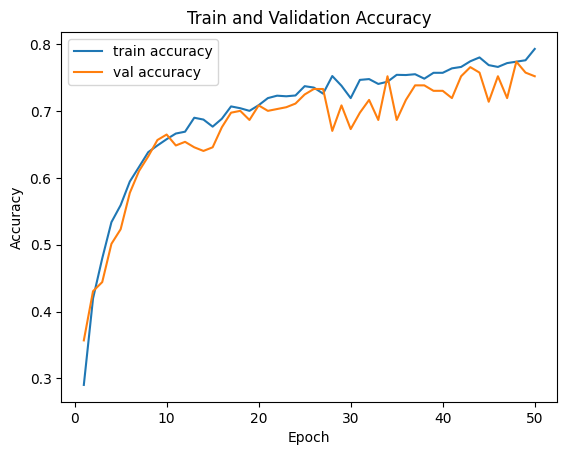

In [14]:
x = [i+1 for i in range(NUM_EPOCHS)]
plt.plot(x, train_accuracy, label = 'train accuracy')
plt.plot(x, val_accuracy, label = 'val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.plot()
plt.savefig('train_val.pdf')

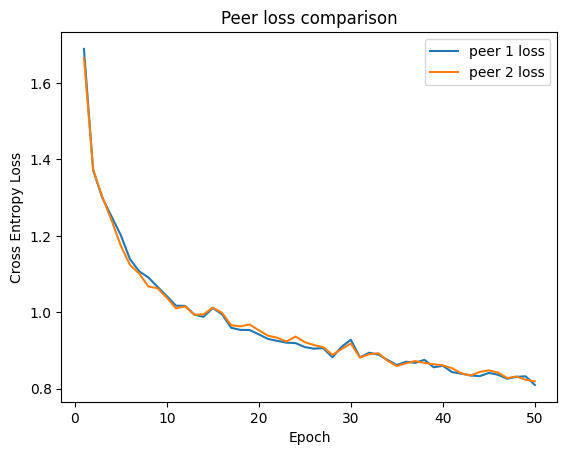

In [15]:
x = [i+1 for i in range(NUM_EPOCHS)]
plt.plot(x, peer1_loss, label = 'peer 1 loss')
plt.plot(x, peer2_loss, label = 'peer 2 loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.title('Peer loss comparison')
plt.plot()
plt.savefig('peer_loss_comparison.pdf')

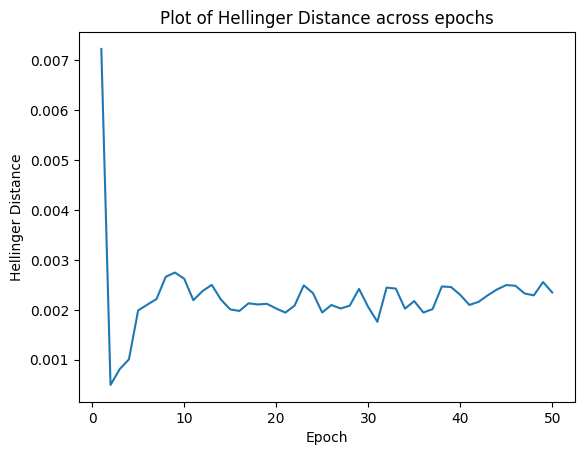

In [16]:
x = [i+1 for i in range(NUM_EPOCHS)]
plt.plot(x, prob_dist)
plt.xlabel('Epoch')
plt.ylabel('Hellinger Distance')
plt.title('Plot of Hellinger Distance across epochs')
plt.plot()
plt.savefig('hellinger_distance.pdf')